In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA

In [2]:
#url='https://www.kaggle.com/kemical/kickstarter-projects/downloads/ks-projects-201801.csv'
#df=pd.read_csv(url, header=None)

In [3]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

https://www.kaggle.com/kromel/kickstarter-successful-vs-failed/data

In [4]:
df=df.sample(1000, random_state=32)

In [5]:
df.shape

(1000, 15)

In [6]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [7]:
df.dtypes

ID                   object
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                 object
launched             object
pledged              object
state                object
backers              object
country              object
usd pledged          object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

# Data Cleaning

### Nulls

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(df_missingData.head(20))
df.isnull().sum().max()

,Total,Percent
usd pledged,8,0.008
usd_goal_real,0,0.000
usd_pledged_real,0,0.000
country,0,0.000
backers,0,0.000
state,0,0.000
pledged,0,0.000
launched,0,0.000
goal,0,0.000
deadline,0,0.000


8

In [9]:
dfNoNulls = df.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  1000
After Dropping Nulls:  992
Rows Removed:  8
Percent Removed: 1%


### "usd pledged" Column: Bad Formatting

In [10]:
dfDropPldg = dfNoNulls.copy()
for row in dfDropPldg.iterrows():
    if str(row[1]['usd pledged']).count('.') > 1:
        print (row)
        dfDrop = dfDropPldg.drop(row[0])
        break;
# Use a comprehension for this

In [11]:
dfDropCntry = dfDropPldg.copy()
dfDropCntry = dfDropCntry.drop(dfDropCntry[(dfDropCntry['country'] != 'US')].index)

In [12]:
dfDropCat = dfDropCntry.copy()
dfDropCat = dfDropCat.drop('category',axis=1)

In [13]:
dfDropState = dfDropCat.copy()
dropVals = ['live','suspended','canceled','fnceled']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

### Convert to Numeric

In [14]:
dfNum = dfDropState.copy()
numCols = ['goal','pledged','backers','usd pledged']
for c in numCols:
    dfNum[c] = dfNum[c].apply(pd.to_numeric)

In [15]:
dfNum.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,7.000000e+02
mean,2.324955e+04,8470.745529,120.361429,6414.505000,8470.745529,2.324955e+04
std,1.286013e+05,31772.481735,492.706359,27647.878257,31772.481735,1.286013e+05
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,2.000000e+03,81.000000,3.000000,35.000000,81.000000,2.000000e+03
50%,5.000000e+03,1102.500000,20.000000,802.000000,1102.500000,5.000000e+03
75%,1.500000e+04,5208.500000,71.000000,4067.750000,5208.500000,1.500000e+04
max,3.000000e+06,588903.000000,9677.000000,588903.000000,588903.000000,3.000000e+06


# Univariate Exploration

In [16]:
def BarPie (col,df_focus):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    
    b = sns.countplot(x=dfNum[col],data=dfNum, ax=ax1)
    plt.setp(b.get_xticklabels(), rotation=90)
    
    labels = df_focus[col].astype('category').cat.categories.tolist()
    counts = df_focus[col].value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
    ax2.axis('equal')
    
    plt.show()

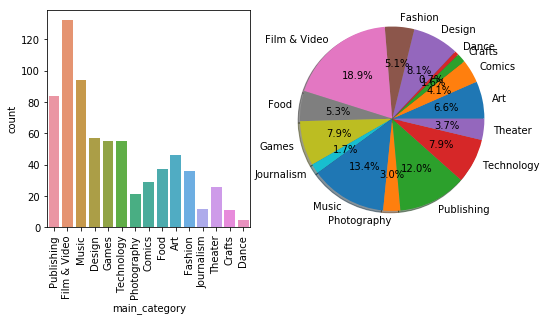

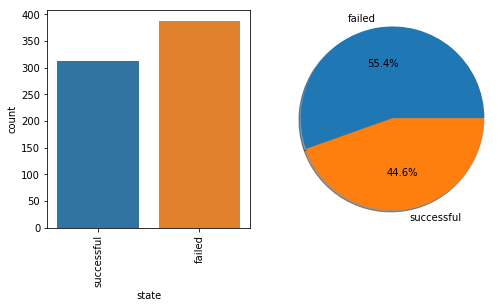

In [17]:
catCols = ['main_category','state']
for col in catCols:
    BarPie(col,dfNum)

In [18]:
def BoxHist(column, df_focus):
    
    sns.set()
    colList = df_focus[column]
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=10)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.show()

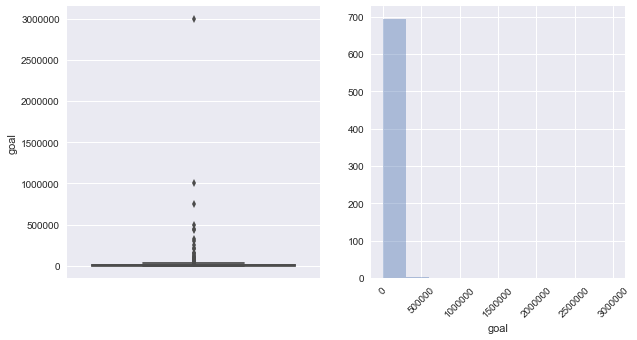

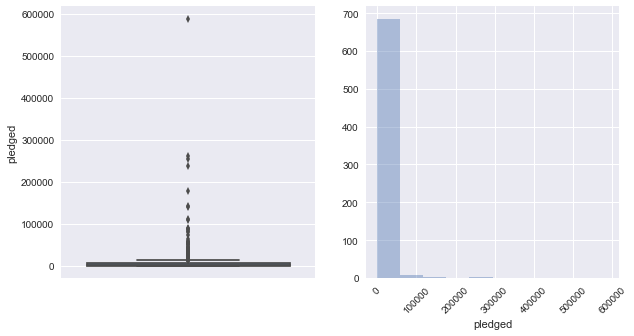

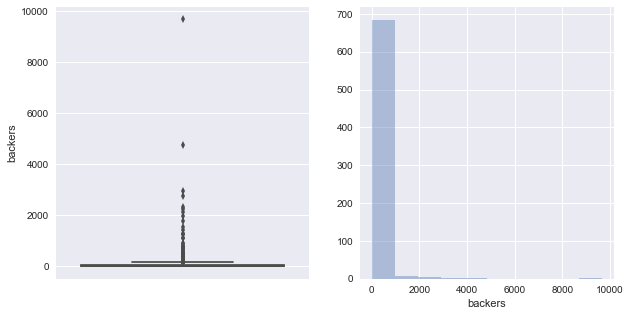

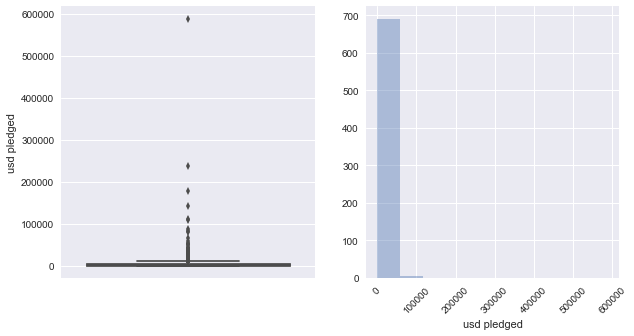

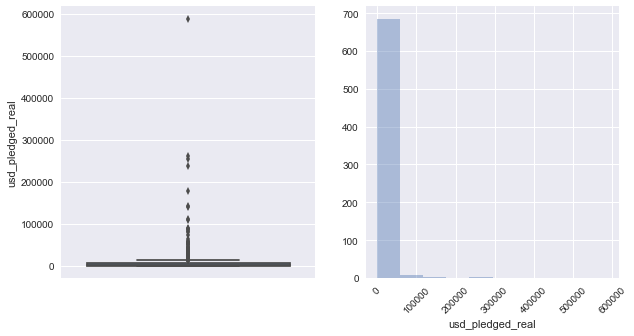

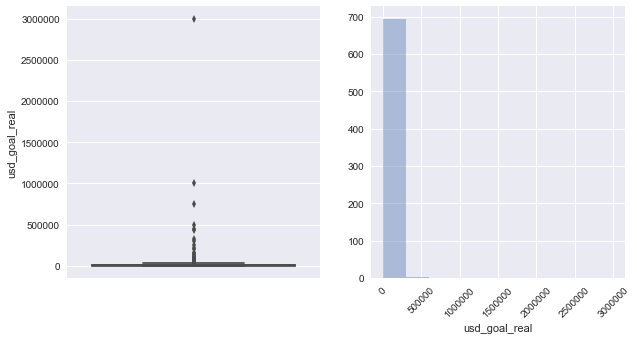

In [19]:
contCols = ['goal','pledged','backers','usd pledged', 'usd_pledged_real', 'usd_goal_real']
for col in contCols:
    BoxHist(col,dfNum)

# Bivariate Exploration

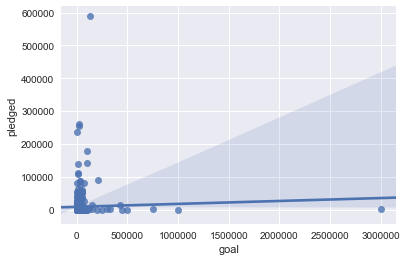

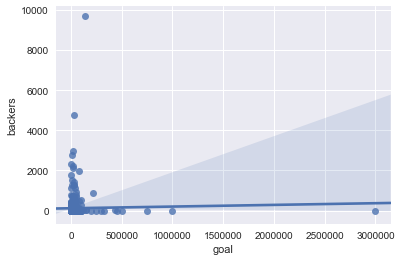

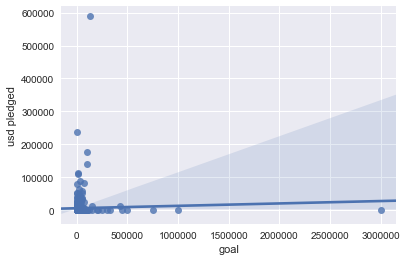

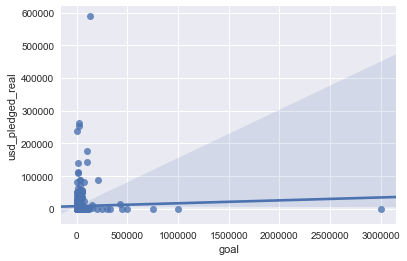

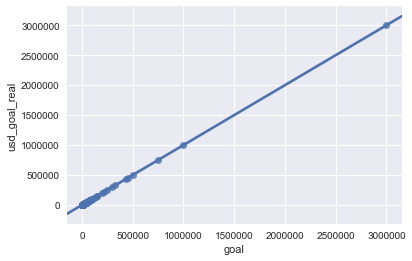

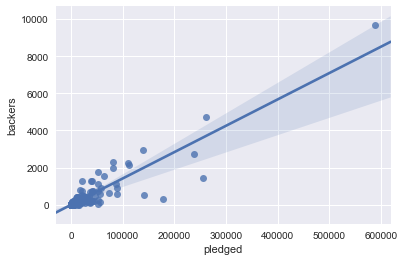

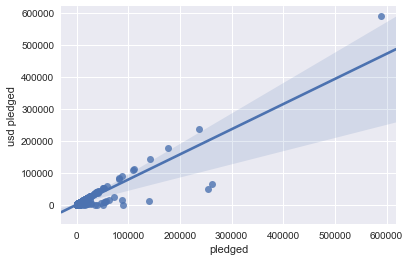

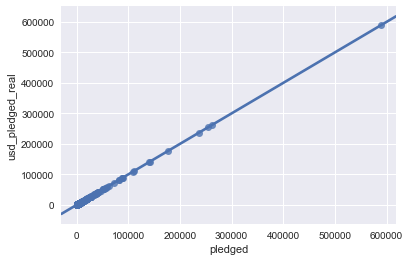

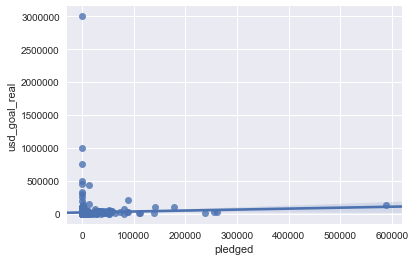

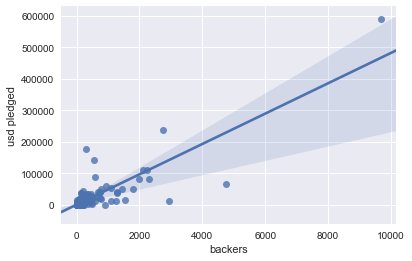

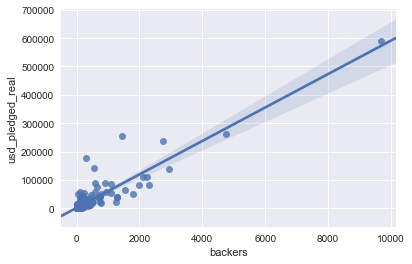

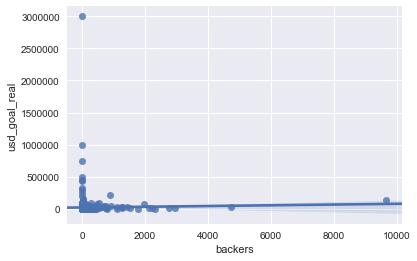

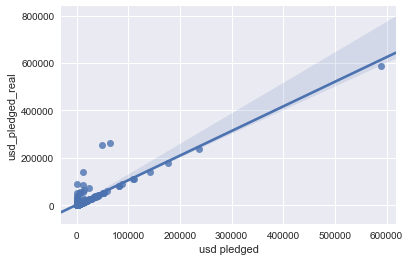

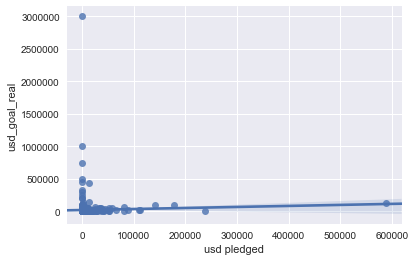

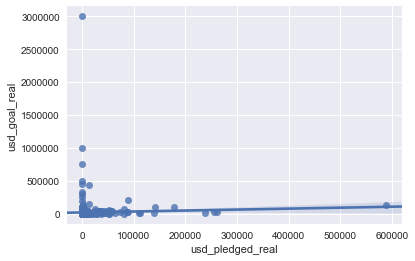

In [20]:
graphlog = []
for colx in contCols:
    for coly in contCols:
        logItem = coly+colx
        if (colx != coly) & (colx+coly not in graphlog):
            ax = sns.regplot(x=colx,y=coly, data=dfNum)
            graphlog.append(coly+colx)
            plt.show()

# Encoding

In [21]:
sorted(dfNum.state.unique())

['failed', 'successful']

In [22]:
dfEnc = pd.DataFrame()
dfEnc = dfNum.copy()
dfEnc['state'] = dfNum.state.astype('category')
dfEnc['state_code'] = np.where(dfEnc['state'].str.contains('successful'),1,0)

In [23]:
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

In [24]:
dfEnc.shape

(700, 29)

In [25]:
dfEnc.head()

,ID,name,currency,deadline,goal,launched,pledged,state,backers,country,...,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,USD,2012-07-12,1000.0,2012-06-28 01:35:01,1505.0,successful,43.0,US,...,0,0,0,0,0,0,0,1,0,0
867977,7.40164e+08,The Toughest,USD,2016-04-02,2295.0,2016-03-03 15:46:40,0.0,failed,0.0,US,...,0,1,0,0,0,0,0,0,0,0
552989,2.11333e+08,"""I Shut My Eyes""",USD,2013-04-18,2000.0,2013-03-19 19:19:06,2001.0,successful,21.0,US,...,0,1,0,0,0,0,0,0,0,0
26021,1062147209,Revolution Hymns - an album by Andy Livingston,USD,2012-09-30,2500.0,2012-08-16 18:24:20,60.0,failed,3.0,US,...,0,0,0,0,0,1,0,0,0,0
996250,869130927,Jews With Tools,USD,2012-02-05,3000.0,2011-12-07 18:15:04,360.0,failed,12.0,US,...,0,0,0,0,0,0,0,1,0,0


# Set Data and Target

In [26]:
contCols

['goal',
 'pledged',
 'backers',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real']

In [27]:
dataCols = []
dataCols += contCols
dataCols += [col for col in dfEnc.columns if 'cat_' in col]

In [28]:
dataCols

['goal',
 'pledged',
 'backers',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real',
 'cat_Art',
 'cat_Comics',
 'cat_Crafts',
 'cat_Dance',
 'cat_Design',
 'cat_Fashion',
 'cat_Film & Video',
 'cat_Food',
 'cat_Games',
 'cat_Journalism',
 'cat_Music',
 'cat_Photography',
 'cat_Publishing',
 'cat_Technology',
 'cat_Theater']

In [29]:
y=dfEnc['state_code']
X=dfEnc[dataCols]

In [30]:
X.shape

(700, 21)

In [31]:
X.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,cat_Art,cat_Comics,cat_Crafts,cat_Dance,...,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
443026,1000.0,1505.0,43.0,1505.0,1505.0,1000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
867977,2295.0,0.0,0.0,0.0,0.0,2295.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
552989,2000.0,2001.0,21.0,2001.0,2001.0,2000.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
26021,2500.0,60.0,3.0,60.0,60.0,2500.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
996250,3000.0,360.0,12.0,360.0,360.0,3000.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Baseline

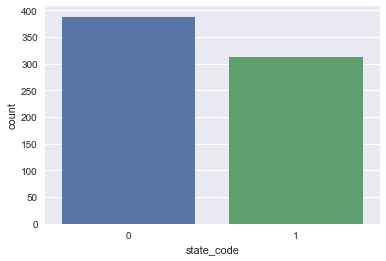

BASELINE: 0.8041237113402062


In [32]:
from collections import Counter

g = sns.countplot(x=y, data=X)
plt.show()
counts = Counter(y)
print ("BASELINE: {}".format(counts[1]/counts[0]))

# Tuning

In [33]:
def GridSearchTablePlot(gridClf, paramName,
                          num_results=15,
                          negative=True,
                          graph=True,
                          displayAllParams=False,
                          largeTable=False):

    '''Display grid search results

    Arguments
    ---------

    gridClf           the estimator resulting from a grid search
                       for example: gridClf = GridSearchCV( ...

    paramName         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    displayAllParams boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearchTablePlot(gridClf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = gridClf.best_estimator_
    clf_params = gridClf.best_params_
    if negative:
        clf_score = -gridClf.best_score_
    else:
        clf_score = gridClf.best_score_
    clf_stdev = gridClf.cv_results_['std_test_score'][gridClf.best_index_]
    cv_results = gridClf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if displayAllParams:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + paramName]

 
    # display abreviated top 'num_results' results
    # ===================================== 

    if largeTable:
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    else:
        abrevCols = ['mean_test_score','std_test_score']
        abrevCols += [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results)[abrevCols])
        

    # plot the results
    # ================
    [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
    scores_df = scores_df.sort_values(by='param_' + paramName)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + paramName]

    # plot
    if graph:
        plt.figure(figsize=(8, 4))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(paramName + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(paramName)
        plt.ylabel('Score')
        plt.show()

### Ridge

In [34]:
params = {'alpha':np.linspace(17,35,num=20)}
gslrr = GridSearchCV(linear_model.RidgeClassifier(), params, return_train_score=True, n_jobs=4)
gsOut = gslrr.fit(X,y)

best parameters: {'alpha': 32.157894736842103}
best score:      0.71429 (+/-0.01693)


,mean_test_score,std_test_score,param_alpha
16,0.714286,0.016935,32.1579
19,0.712857,0.015601,35
4,0.712857,0.007504,20.7895
18,0.712857,0.015601,34.0526
15,0.712857,0.014918,31.2105
17,0.711429,0.012904,33.1053
1,0.710000,0.013615,17.9474
2,0.710000,0.011138,18.8947
3,0.710000,0.011138,19.8421
5,0.710000,0.005898,21.7368


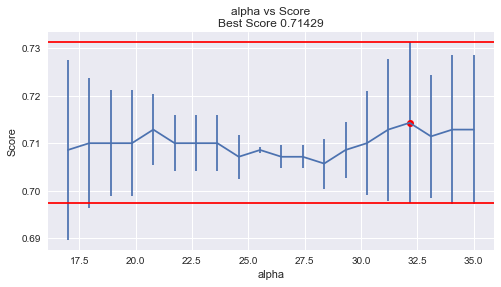

In [35]:
GridSearchTablePlot(gslrr,"alpha", negative=False)

### Lasso

In [36]:
lassoParams = {'alpha':np.linspace(.00002,.0001,20)}

In [37]:
gslsr = GridSearchCV(linear_model.Lasso(), lassoParams, return_train_score=True, n_jobs=4)
gsOut = gslsr.fit(X,y)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'alpha': 2.0000000000000002e-05}
best score:      -0.02316 (+/-0.20641)


,mean_test_score,std_test_score,param_alpha
0,-0.023159,0.206409,2e-05
1,-0.023177,0.206469,2.42105e-05
2,-0.023195,0.206530,2.84211e-05
3,-0.023212,0.206591,3.26316e-05
4,-0.023230,0.206652,3.68421e-05
5,-0.023248,0.206713,4.10526e-05
6,-0.023267,0.206774,4.52632e-05
7,-0.023285,0.206835,4.94737e-05
8,-0.023303,0.206896,5.36842e-05
9,-0.023322,0.206957,5.78947e-05


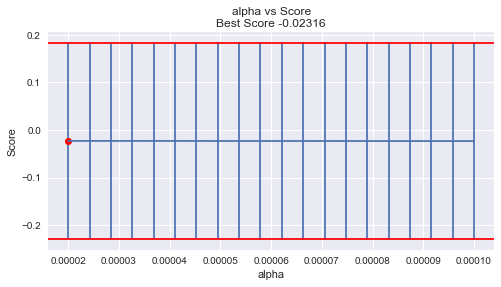

In [38]:
GridSearchTablePlot(gslsr,"alpha", negative=False)

### KNN

In [39]:
knnParams = {'n_neighbors':range(1,4),
          'weights':('uniform','distance')}

In [40]:
gsknn=GridSearchCV(KNeighborsClassifier(),knnParams,return_train_score=True, n_jobs=4)
gsknn.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': range(1, 4), 'weights': ('uniform', 'distance')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
best score:      0.99143 (+/-0.00607)


,mean_test_score,std_test_score,param_n_neighbors,param_weights
0,0.991429,0.006072,1,uniform
1,0.991429,0.006072,1,distance
3,0.991429,0.006072,2,distance
4,0.990000,0.005353,3,uniform
5,0.990000,0.005353,3,distance
2,0.987143,0.003521,2,uniform


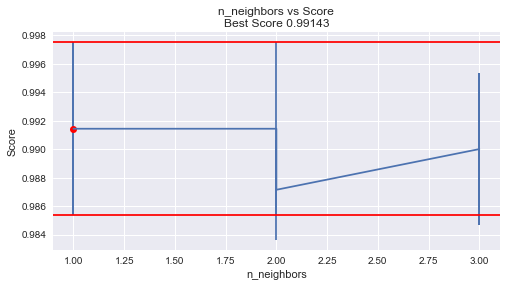

In [41]:
GridSearchTablePlot(gsknn,"n_neighbors", negative=False)

### Decision Tree

In [42]:
dtparams = {'max_features': range(1,len(X.columns)),
         'max_depth': range(10,20),
         'criterion':('entropy','gini')}
dtgs = GridSearchCV(tree.DecisionTreeClassifier(), dtparams, return_train_score=True, n_jobs=4)
dtgs.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_features': range(1, 21), 'max_depth': range(10, 20), 'criterion': ('entropy', 'gini')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best parameters: {'criterion': 'entropy', 'max_depth': 14, 'max_features': 7}
best score:      0.97429 (+/-0.00611)


,mean_test_score,std_test_score,param_criterion,param_max_depth,param_max_features
86,0.974286,0.006109,entropy,14,7
152,0.972857,0.005386,entropy,17,13
70,0.972857,0.008849,entropy,13,11
69,0.971429,0.008855,entropy,13,10
106,0.971429,0.005397,entropy,15,7
352,0.971429,0.019939,gini,17,13
177,0.971429,0.005338,entropy,18,18
75,0.970000,0.010505,entropy,13,16
109,0.970000,0.010547,entropy,15,10
98,0.970000,0.012660,entropy,14,19


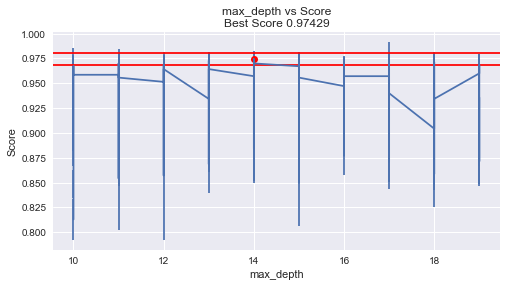

In [43]:
GridSearchTablePlot(dtgs,"max_depth", negative=False)

### Random Forest

In [44]:
rfparams = {'n_estimators':range(15,25),
        'max_features': range(1,len(X.columns)),
         'max_depth': range(15,25),
         'criterion':('entropy','gini')}
rfgs = GridSearchCV(ensemble.RandomForestClassifier(), rfparams, return_train_score=True, n_jobs=4)
rfgs.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(15, 25), 'max_features': range(1, 21), 'max_depth': range(15, 25), 'criterion': ('entropy', 'gini')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best parameters: {'criterion': 'entropy', 'max_depth': 23, 'max_features': 10, 'n_estimators': 22}
best score:      0.98571 (+/-0.00204)


,mean_test_score,std_test_score,param_criterion,param_max_depth,param_max_features,param_n_estimators
1713,0.985714,0.002036,entropy,23,12,18
1697,0.985714,0.002036,entropy,23,10,22
55,0.984286,0.005343,entropy,15,6,20
1351,0.982857,0.006091,entropy,21,16,16
1532,0.982857,0.006091,entropy,22,14,17
1142,0.982857,0.006091,entropy,20,15,17
1899,0.982857,0.003528,entropy,24,10,24
368,0.982857,0.003528,entropy,16,17,23
1146,0.982857,0.000035,entropy,20,15,21
1461,0.982857,0.006091,entropy,22,7,16


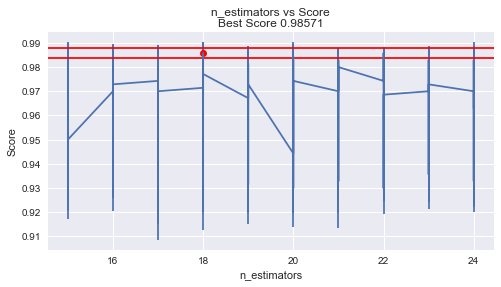

In [45]:
GridSearchTablePlot(rfgs,"n_estimators", negative=False)

### SVM

In [46]:
svcParams = {'C':range(1,6)}
svcgs = GridSearchCV(SVC(), svcParams, return_train_score=True, n_jobs=4)
svcgs.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4, param_grid={'C': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best parameters: {'C': 2}
best score:      0.56286 (+/-0.00088)


,mean_test_score,std_test_score,param_C
1,0.562857,0.000883,2
2,0.562857,0.000883,3
3,0.562857,0.000883,4
4,0.562857,0.000883,5
0,0.561429,0.002580,1


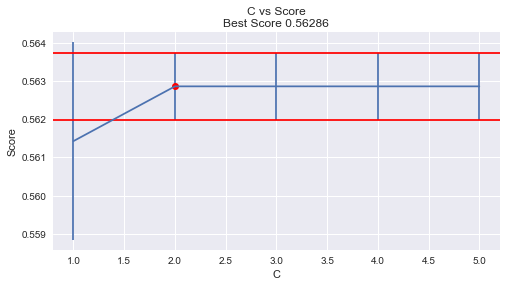

In [47]:
GridSearchTablePlot(svcgs,"C", negative=False)

### Gradient Boost

In [48]:
gbparams = {'n_estimators':range(50,120,5),
         'max_depth': range(7,10),
         'loss':('deviance','exponential')}
gbgs = GridSearchCV(ensemble.GradientBoostingClassifier(), gbparams, return_train_score=True, n_jobs=4)
gbgs.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(50, 120, 5), 'max_depth': range(7, 10), 'loss': ('deviance', 'exponential')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

best parameters: {'loss': 'deviance', 'max_depth': 9, 'n_estimators': 100}
best score:      0.96714 (+/-0.01074)


,mean_test_score,std_test_score,param_loss,param_max_depth,param_n_estimators
38,0.967143,0.010740,deviance,9,100
68,0.967143,0.010740,exponential,8,110
83,0.965714,0.010554,exponential,9,115
46,0.965714,0.009305,exponential,7,70
48,0.965714,0.009305,exponential,7,80
36,0.965714,0.009305,deviance,9,90
34,0.965714,0.009305,deviance,9,80
50,0.965714,0.010554,exponential,7,90
27,0.965714,0.010554,deviance,8,115
25,0.965714,0.009305,deviance,8,105


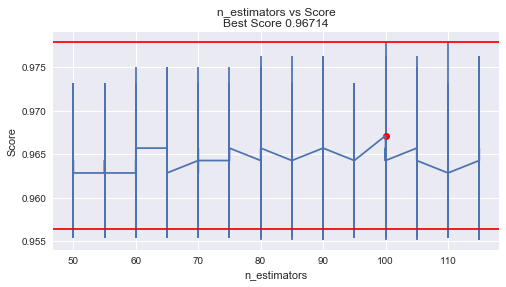

In [49]:
GridSearchTablePlot(gbgs,"n_estimators", negative=False)


# Models 

In [50]:
import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues()
    
    def setCommonValues(self,name,X,Y):
        self.name = name
        self.X = X
        self.Y = Y
    
    def setModelSpecificValues(self): pass
    
    def setValues(self,name,X,Y):
        self.setCommonValues(name,X,Y)   
    
    def initValues(self):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToFit = end - start
        self.rSquared = self.modelObj.score(self.X, self.Y)
        self.crossVal = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.crossValMean = np.mean(self.crossVal)
        self.crossValRange = max(self.crossVal) - min(self.crossVal)
         
    def performance(self, boxPlot=True):
        print ("Model: " + self.name)
        print ("r-squared:" + str(self.rSquared))
        print ("Cross Validation Mean:" + str(self.crossValMean))
        print ("Cross Validation Range: " + str(self.crossValRange))
        print ("Time to Fit:" + str(self.timeToFit))
        print ("Cross Validation Scores: ")
        print (self.crossVal)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.crossVal)
            ax.set_xticklabels(self.name)
            plt.show()
    
    def compareFolds(self, modelRight):
        fmt = '{:<2}{:<20}|{:<10}'
        a_left = self.crossVal
        a_right = modelRight.crossVal
        a_left.sort()
        a_right.sort()
        
        print("CROSS VALIDATION SCORES")
        print(fmt.format('',self.name,modelRight.name))
        for i, (left, right) in enumerate(zip(a_left, a_right)):
            print(fmt.format(i, left, right))
            
    def compareR(self,modelRight):
        fmt = '{:<2}{:<20}|{:<20}'
        
        print("R-SQUARED")
        print(fmt.format('',self.name,modelRight.name))
        print(fmt.format('',self.rSquared,modelRight.rSquared))
        
    def comparecrossValMean(self,modelRight):
        fmt = '{:<2}{:<20}|{:<20}'
        
        print("CROSS VALIDATION MEAN")
        print(fmt.format('',self.name,modelRight.name))
        print(fmt.format('',self.crossValMean,modelRight.crossValMean))
    
    def comparecrossValRange(self,modelRight):
        fmt = '{:<2}{:<20}|{:<20}'
        
        print("CROSS VALIDATION RANGE")
        print(fmt.format('',self.name,modelRight.name))
        print(fmt.format('',self.crossValRange,modelRight.crossValRange))
    
    def compareTimeToFit(self,modelRight):
        fmt = '{:<2}{:<20}|{:<20}'
        
        print("TIME TO FIT")
        print(fmt.format('',self.name,modelRight.name))
        print(fmt.format('',self.timeToFit,modelRight.timeToFit))
    
    def compareBox(self,modelList,filter=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filter > 0:
                if rightModel.crossVal.mean() > filter:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()

    def compareList(self,modelList,filter=0, newTitle=''):
        results = []
        names = []
        fmt = '{:<2}{:<20}|{:<20}'
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filter > 0:
                if rightModel.crossVal.mean() > filter:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
                    fmt = fmt.append('|{:<20}')
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
                fmt = fmt.append('|{:<20}')
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'R Sqr':model.rSquared,
                                'CV Mean':model.crossValMean,
                                'CV Range': model.crossValRange}
            cvNameList= []
            for idx,cv in enumerate(model.crossVal):
                cvName = 'CV Fold ' + str(idx+1)
                cvNameList.append(cvName)
                dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        
        colOrder = ['Name', 'R Sqr', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)
    
    def fullCompare(self,modelRight):
        self.compareR(modelRight)
        self.compareTimeToFit(modelRight)
        self.comparecrossValMean(modelRight)
        self.comparecrossValRange(modelRight)
        self.compareFolds(modelRight)
        modelList = []
        modelList.append(modelRight)
        self.compareBox(modelList)
        

### Naive Bayes

Model: Naive Bayes
r-squared:0.66
Cross Validation Mean:0.66004679539
Cross Validation Range: 0.118541033435
Time to Fit:0.0029439926147460938
Cross Validation Scores: 
[ 0.68085106  0.59574468  0.71428571  0.67625899  0.63309353]


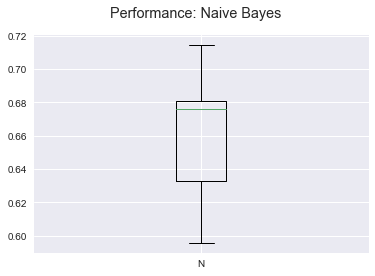

In [51]:
nbModel = Model('Naive Bayes',X,y,BernoulliNB())
nbModel.performance()

### Logistic Regression (Vanilla)

Model: Vanilla Reg
r-squared:1.0
Cross Validation Mean:0.998561151079
Cross Validation Range: 0.00719424460432
Time to Fit:0.004578113555908203
Cross Validation Scores: 
[ 1.          1.          1.          1.          0.99280576]


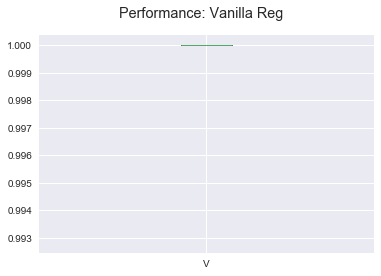

In [52]:
vanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
vanRegModel = Model('Vanilla Reg',X,y,LogisticRegression(),**vanRegModelParams)
vanRegModel.performance()

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_

Model: Vanilla Reg
r-squared:0.187322441083
Cross Validation Mean:-0.0247034505382
Cross Validation Range: 0.502074279081
Time to Fit:0.018743038177490234
Cross Validation Scores: 
[ 0.14925346  0.1360824  -0.35282082 -0.13027195  0.07423966]


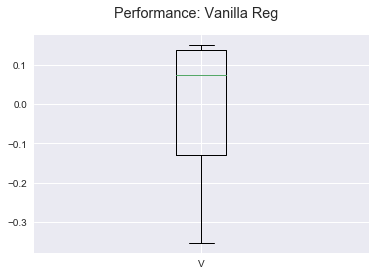

In [53]:
vanRegModelParams = {'alpha': 0}
vanRegModel = Model('Vanilla Reg',X,y,linear_model.Lasso(),**vanRegModelParams)
vanRegModel.performance()

### KNN

Model: KNN
r-squared:1.0
Cross Validation Mean:0.992836442093
Cross Validation Range: 0.0215827338129
Time to Fit:0.002015829086303711
Cross Validation Scores: 
[ 0.9929078   1.          0.99285714  1.          0.97841727]


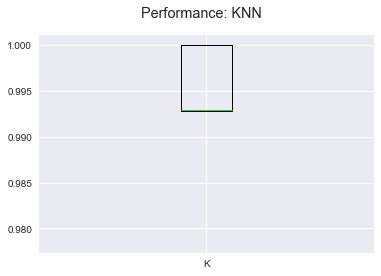

In [54]:
knnModelParams = {'n_neighbors': 1,
               'weights': 'distance'}
knnModel = Model('KNN',X,y,KNeighborsClassifier(),**knnModelParams)
knnModel.performance()

### Decision Tree

Model: D Tree
r-squared:1.0
Cross Validation Mean:0.945762903355
Cross Validation Range: 0.056484295846
Time to Fit:0.002872943878173828
Cross Validation Scores: 
[ 0.90780142  0.95744681  0.96428571  0.94244604  0.95683453]


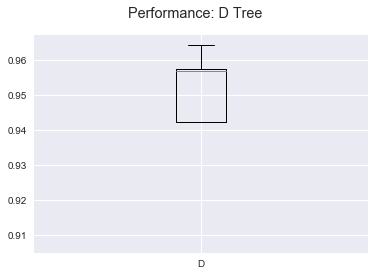

In [55]:
dtModelParams = {'max_features':5, 
                 'max_depth':18, 
                 'criterion':'gini'}
dtModel = Model('D Tree',X,y,tree.DecisionTreeClassifier(),**dtModelParams)
dtModel.performance()

### SVM

Model: SVM
r-squared:1.0
Cross Validation Mean:0.565747596452
Cross Validation Range: 0.0223480789836
Time to Fit:0.04368400573730469
Cross Validation Scores: 
[ 0.56737589  0.55319149  0.56428571  0.57553957  0.56834532]


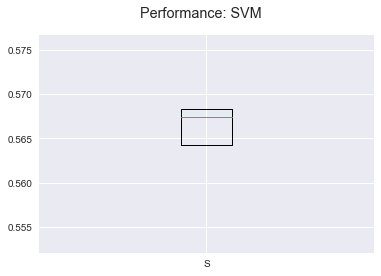

In [56]:
svmModelParams = {'C':2}
svmModel = Model('SVM',X,y,SVC(),**svmModelParams)
svmModel.performance()

### Random Forest

Model: Random Forest
r-squared:1.0
Cross Validation Mean:0.972886517534
Cross Validation Range: 0.0282674772036
Time to Fit:0.03607606887817383
Cross Validation Scores: 
[ 0.95744681  0.97163121  0.98571429  0.97122302  0.97841727]


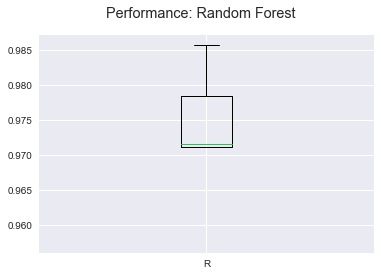

In [57]:
rfModelParams = {'n_estimators':22,
                 'max_depth':19,
                 'max_features':4,
                 'criterion':'gini'}
rfModel = Model('Random Forest',X,y,ensemble.RandomForestClassifier(),**rfModelParams)
rfModel.performance()

### Gradient Boost

Model: Gradient Boost
r-squared:1.0
Cross Validation Mean:0.974284693825
Cross Validation Range: 0.00750038267259
Time to Fit:0.2413320541381836
Cross Validation Scores: 
[ 0.97163121  0.9787234   0.97142857  0.97841727  0.97122302]


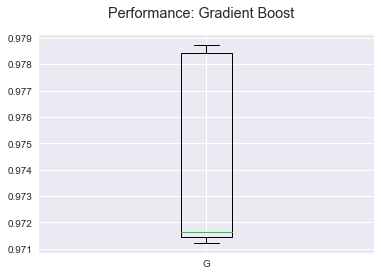

In [58]:
gbModelParams = {'n_estimators':142,
                 'max_depth':8,
                 'loss':'deviance'}
gbModel = Model('Gradient Boost',X,y,ensemble.GradientBoostingClassifier(),**gbModelParams)
gbModel.performance()

### Ridge

Model: Ridge Reg
r-squared:1.0
Cross Validation Mean:0.998561151079
Cross Validation Range: 0.00719424460432
Time to Fit:0.004530906677246094
Cross Validation Scores: 
[ 1.          1.          1.          1.          0.99280576]


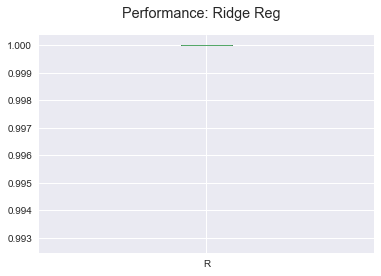

In [59]:
ridgeRegModelParams = {'C': .62,
               'penalty': 'l2'}
ridgeRegModel = Model('Ridge Reg',X,y,LogisticRegression(),**ridgeRegModelParams)
ridgeRegModel.performance()

Model: Ridge Reg
r-squared:1.0
Cross Validation Mean:0.998561151079
Cross Validation Range: 0.00719424460432
Time to Fit:0.004350900650024414
Cross Validation Scores: 
[ 1.          1.          1.          1.          0.99280576]


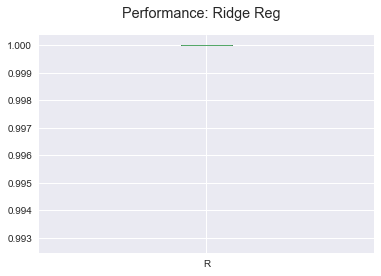

In [60]:
ridgeRegModelParams = {'C': 62,
               'penalty': 'l2'}
ridgeRegModel = Model('Ridge Reg',X,y,LogisticRegression(),**ridgeRegModelParams)
ridgeRegModel.performance()

Model: Ridge Reg
r-squared:0.702857142857
Cross Validation Mean:0.69134438346
Cross Validation Range: 0.0851063829787
Time to Fit:0.004018068313598633
Cross Validation Scores: 
[ 0.65957447  0.74468085  0.70714286  0.66906475  0.67625899]


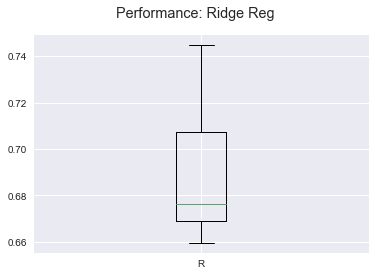

In [61]:
ridgeRegModelParams = {'alpha': 62}
ridgeRegModel = Model('Ridge Reg',X,y,linear_model.RidgeClassifier(),**ridgeRegModelParams)
ridgeRegModel.performance()

### Lasso

Model: Lasso Reg
r-squared:0.992857142857
Cross Validation Mean:0.9928261646
Cross Validation Range: 0.0215827338129
Time to Fit:0.12423396110534668
Cross Validation Scores: 
[ 1.          0.9929078   1.          0.99280576  0.97841727]


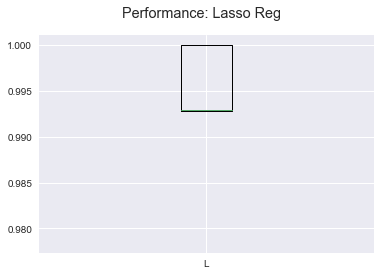

In [62]:
lassoRegModelParams = {'C': .0689474,
               'penalty': 'l1'}
lassoRegModel = Model('Lasso Reg',X,y,LogisticRegression(),**lassoRegModelParams)
lassoRegModel.performance()

# Feature Selection

### PCA

In [63]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=21, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

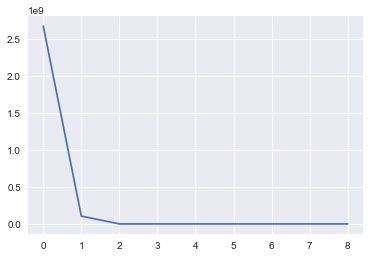

In [64]:
plt.plot(pca.explained_variance_[1:10])
plt.show()

In [65]:
pca2=PCA(n_components=2)
pca2out = pca2.fit_transform(X)
pca2.score

<bound method PCA.score of PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>

In [66]:
#modelPCA = svm.SVC()
#cross_val_score(modelPCA,pca2out,Y,cv=5)

### Lasso

In [67]:
lrFeatSel = LogisticRegression(C=.00001, penalty='l1')
lrFeatSel.fit(X,y)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
coefDict = {}
for coef, feat in zip(lrFeatSel.coef_[0], X.columns):
    coefDict[feat] = coef
lassoFeats = list({f for f, c in coefDict.items() if c != 0.0})

In [69]:
lassoFeats

['pledged', 'usd_goal_real', 'goal', 'usd_pledged_real']

# Model Comparisons

# Low Performers

,Name,R Sqr,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,Ridge Reg,0.702857,0.691344,0.085106,0.004018,0.659574,0.744681,0.707143,0.669065,0.676259
1,Vanilla Reg,0.187322,-0.024703,0.502074,0.018743,0.149253,0.136082,-0.352821,-0.130272,0.074240
2,Naive Bayes,0.660000,0.660047,0.118541,0.002944,0.680851,0.595745,0.714286,0.676259,0.633094
3,SVM,1.000000,0.565748,0.022348,0.043684,0.567376,0.553191,0.564286,0.575540,0.568345


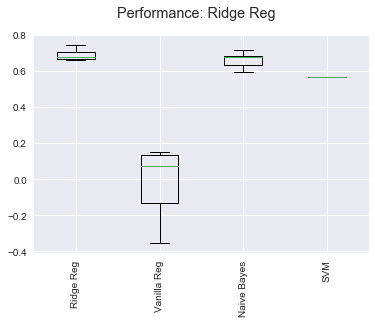

In [74]:
ridgeRegModel.fullCompareList([vanRegModel, nbModel,svmModel])

### High Performers

,Name,R Sqr,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,Lasso Reg,0.992857,0.992826,0.021583,0.124234,1.000000,0.992908,1.000000,0.992806,0.978417
1,D Tree,1.000000,0.945763,0.056484,0.002873,0.907801,0.957447,0.964286,0.942446,0.956835
2,Random Forest,1.000000,0.972887,0.028267,0.036076,0.957447,0.971631,0.985714,0.971223,0.978417
3,Gradient Boost,1.000000,0.974285,0.007500,0.241332,0.971631,0.978723,0.971429,0.978417,0.971223


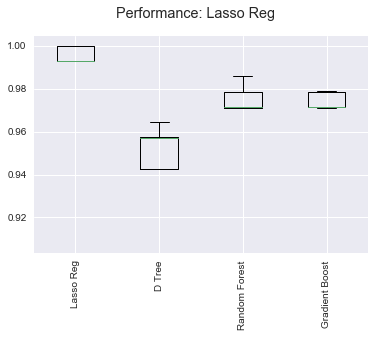

In [73]:
lassoRegModel.fullCompareList([dtModel, rfModel,gbModel])